# Analysis of Medicare Claims Data, for Medicare Beneficiaries with Opioid Dependence Diagnoses

Prompt: To manipulate a subset of claims that map to patients diagnosed with opioid dependence.

My goal in this analysis is to perform exploratory data analysis to see whether there may be some investment signals in this data related to opioid dependence. Theoretically this should help in determining whether manufacturers of drugs that treat opioid dependence are accessing the full extent of the growth in the market / patient population.

In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

## Load Outpatient data

The `CMS Outpatient Claims DE-SynPUF` contains synthetic institutional claims for outpatient services provided to the synthetic Medicare beneficiaries. It contains 76 variables, for which you can find definitions [here](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/SynPUF_Codebook.pout_df). Each record pertains to a synthetic outpatient claim. 

Most variables are self explanatory; however, a majority of the variables relate to diagnosis, procedure, or revenue codes, as follows:

- **ICD-9-DGNS (Diagnosis)**: diagnosis codes, which are relevant for our analysis.
- **ICD-9-PRCDR (Procedure)**: procedure codes, most of which are missing because these are meant to be used for inpatient procedures only.
- **HCPCS (Diagnosis)**: HCPCS codes are used to represent medical procedures to Medicare, Medicaid, and several other third-party payers.

Source: http://www.icppharm.com/News-Resources/Articles/Archive-Articles/ICD-10-It’s-closer-than-it-seems.aspx

In [110]:
out_df = pd.read_csv('./DE1_0_2008_to_2010_Outpatient_Claims_Sample_1.csv',
                     dtype={'AT_PHYSN_NPI': 'str',
                            'OP_PHYSN_NPI': 'str',
                            'OT_PHYSN_NPI': 'str'})

In [111]:
# This is the shape of our dataframe (columns x rows)
len(out_df.columns), len(out_df)

(76, 790790)

#### Obtain only rows containing ICD-9 codes beginning with '3040'

Below is a list containing the column names of ICD-9 Diagnosis codes:

In [112]:
icd_diag = list(out_df.columns[12:22])
icd_diag

['ICD9_DGNS_CD_1',
 'ICD9_DGNS_CD_2',
 'ICD9_DGNS_CD_3',
 'ICD9_DGNS_CD_4',
 'ICD9_DGNS_CD_5',
 'ICD9_DGNS_CD_6',
 'ICD9_DGNS_CD_7',
 'ICD9_DGNS_CD_8',
 'ICD9_DGNS_CD_9',
 'ICD9_DGNS_CD_10']

#### Convert columns containing dates to DateTime format

In [113]:
out_df['CLM_FROM_DT'] = pd.to_datetime(out_df['CLM_FROM_DT'].astype(str), format='%Y%m%d')
out_df['CLM_THRU_DT'] = pd.to_datetime(out_df['CLM_THRU_DT'].astype(str), format='%Y%m%d')

#### Add a year column

In [115]:
out_df['year'] = out_df['CLM_THRU_DT'].dt.to_period('Y')
out_df['year'] = out_df['year'].astype(str)

## Analysis: Outpatients diagnosed with opioid abuse
Okay, now that we've loaded the data and made some formatting changes, let's pull some numbers from the data. First, let's create an index corresponding to any rows that contain one of our relevant ICD codes:

In [116]:
out_index = list(
    out_df[icd_diag][out_df[icd_diag].isin(
        ['30400','30401','30402','30403']
    ).any(axis=1)].index
)

Then, we can filter our dataframe to show only those beneficiaries that corresponding to our selected Diagnosis codes. There are 212 unique beneficiaries diagnosed with `Opioid Dependency` in our sample:

In [219]:
out_ids = list(out_df.iloc[out_index]['DESYNPUF_ID'].unique())
out_df.iloc[out_index]['DESYNPUF_ID'].nunique()

212

Let's check how many unique cumulative beneficiaries there are in our sample from a 1-year, 2-year, and 3-year cumulative perspective (prevalence):

In [179]:
print("Number of Inpatient beneficiaries for whom an opioid dependency claim was submitted")
print("2008:", out_df.iloc[out_index][out_df.iloc[out_index]['year'].isin(['2008'])]['DESYNPUF_ID'].nunique())
print("2008-2009:", out_df.iloc[out_index][out_df.iloc[out_index]['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique())
print("2008-2010:", out_df.iloc[out_index][out_df.iloc[out_index]['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique())

Number of beneficiaries for whom an opioid dependency claim was submitted
2008: 73
2008-2009: 161
2008-2010: 212


In [181]:
print("Number of total Inpatient Medicare beneficiaries for whom any claim was submitted")
print("2008:", out_df[out_df['year'].isin(['2008'])]['DESYNPUF_ID'].nunique())
print("2008-2009:", out_df[out_df['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique())
print("2008-2010:", out_df[out_df['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique())

Number of total Medicare beneficiaries for whom any claim was submitted
2008: 59609
2008-2009: 77732
2008-2010: 85238


In [216]:
print("Prevalence (%) of opioid dependency in total Inpatient Medicare beneficiaries")
print("2008:", "{0:.3%}".format(out_df.iloc[out_index][out_df.iloc[out_index]['year'].isin(['2008'])]['DESYNPUF_ID'].nunique() / out_df[out_df['year'].isin(['2008'])]['DESYNPUF_ID'].nunique()))
print("2008-2009:", "{0:.3%}".format(out_df.iloc[out_index][out_df.iloc[out_index]['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique() / out_df[out_df['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique()))
print("2008-2010:", "{0:.3%}".format(out_df.iloc[out_index][out_df.iloc[out_index]['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique() / out_df[out_df['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique()))

Prevalence (%) of opioid dependency in total Medicare beneficiaries
2008: 0.122%
2008-2009: 0.207%
2008-2010: 0.249%


Let's plot the above data.

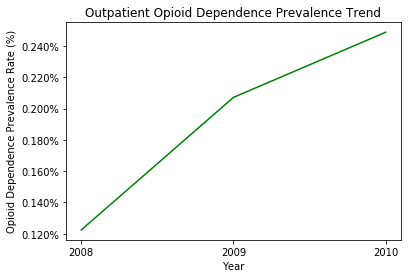

In [415]:
year = ['2008', '2009', '2010']
in_rate = [out_df.iloc[out_index][out_df.iloc[out_index]['year'].isin(['2008'])]['DESYNPUF_ID'].nunique() / out_df[out_df['year'].isin(['2008'])]['DESYNPUF_ID'].nunique(),
           out_df.iloc[out_index][out_df.iloc[out_index]['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique() / out_df[out_df['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique(),
           out_df.iloc[out_index][out_df.iloc[out_index]['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique() / out_df[out_df['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique()]

plt.plot(year, in_rate, color='g')
plt.xlabel('Year')
plt.ylabel('Opioid Dependence Prevalence Rate (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Outpatient Opioid Dependence Prevalence Trend')
plt.show()

Wow! It seems that the **prevalence** rate DOUBLED on a cumulative basis in Outpatients from 2008 to 2010. We should look at the prevalence rates in the Inpatient and Carrier data as well!

## Analysis: Inpatients diagnosed with opioid abuse
Because our sample of Medicare outpatients diagnosed with opioid dependence is small (212 samples), it is worth it to get a look at inpatient data to see if we can get a larger sample. First, let's create an index corresponding to any rows that contain one of our relevant ICD codes:

In [196]:
in_df = pd.read_csv('./DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.csv',
                dtype={'AT_PHYSN_NPI': 'str',
                       'OP_PHYSN_NPI': 'str',
                       'OT_PHYSN_NPI': 'str'})

Let's add a year column:

In [201]:
in_df['CLM_FROM_DT'] = pd.to_datetime(in_df['CLM_FROM_DT'].astype(str), format='%Y%m%d')
in_df['CLM_THRU_DT'] = pd.to_datetime(in_df['CLM_THRU_DT'].astype(str), format='%Y%m%d')
in_df['year'] = in_df['CLM_THRU_DT'].dt.to_period('Y')
in_df['year'] = in_df['year'].astype(str)

In [202]:
in_index = list(
    in_df[icd_diag][in_df[icd_diag].isin(
        ['30400','30401','30402','30403']
    ).any(axis=1)].index
)

Then, we can filter our dataframe to show only those beneficiaries that corresponding to our selected Diagnosis codes. There are 239 unique beneficiaries diagnosed with `Opioid Dependency` in our sample:

In [218]:
in_ids = list(in_df.iloc[in_index]['DESYNPUF_ID'].unique())
in_df.iloc[in_index]['DESYNPUF_ID'].nunique()

239

Let's check how many unique cumulative beneficiaries there are in our sample from a 1-year, 2-year, and 3-year cumulative perspective (prevalence):

In [204]:
print("Number of Outpatient beneficiaries for whom an opioid dependency claim was submitted")
print("2008:", in_df.iloc[in_index][in_df.iloc[in_index]['year'].isin(['2008'])]['DESYNPUF_ID'].nunique())
print("2008-2009:", in_df.iloc[in_index][in_df.iloc[in_index]['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique())
print("2008-2010:", in_df.iloc[in_index][in_df.iloc[in_index]['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique())

Number of beneficiaries for whom an opioid dependency claim was submitted
2008: 79
2008-2009: 186
2008-2010: 239


In [205]:
print("Number of total Outpatient Medicare beneficiaries for whom any claim was submitted")
print("2008:", in_df[in_df['year'].isin(['2008'])]['DESYNPUF_ID'].nunique())
print("2008-2009:", in_df[in_df['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique())
print("2008-2010:", in_df[in_df['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique())

Number of total Medicare beneficiaries for whom any claim was submitted
2008: 15745
2008-2009: 29380
2008-2010: 37780


In [217]:
print("Prevalence (%) of opioid dependency in total Outpatient Medicare beneficiaries")
print("2008:", "{0:.3%}".format(in_df.iloc[in_index][in_df.iloc[in_index]['year'].isin(['2008'])]['DESYNPUF_ID'].nunique() / in_df[in_df['year'].isin(['2008'])]['DESYNPUF_ID'].nunique()))
print("2008-2009:", "{0:.3%}".format(in_df.iloc[in_index][in_df.iloc[in_index]['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique() / in_df[in_df['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique()))
print("2008-2010:", "{0:.3%}".format(in_df.iloc[in_index][in_df.iloc[in_index]['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique() / in_df[in_df['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique()))

Prevalence (%) of opioid dependency in total Medicare beneficiaries
2008: 0.502%
2008-2009: 0.633%
2008-2010: 0.633%


Let's plot the above data.

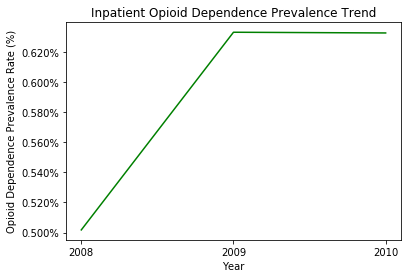

In [416]:
year = ['2008', '2009', '2010']
in_rate = [in_df.iloc[in_index][in_df.iloc[in_index]['year'].isin(['2008'])]['DESYNPUF_ID'].nunique() / in_df[in_df['year'].isin(['2008'])]['DESYNPUF_ID'].nunique(),
           in_df.iloc[in_index][in_df.iloc[in_index]['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique() / in_df[in_df['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique(),
           in_df.iloc[in_index][in_df.iloc[in_index]['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique() / in_df[in_df['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique()]

plt.plot(year, in_rate, color='g')
plt.xlabel('Year')
plt.ylabel('Opioid Dependence Prevalence Rate (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Inpatient Opioid Dependence Prevalence Trend')
plt.show()

Great... so it looks like we were able to find an additional 239 Inpatient beneficiaries that were diagnosed with opioid dependency under ICD codes 30400/30401/30402/30403, out of a total of 37,780 total Inpatient beneficiaries, or **0.6%** of the Inpatient beneficiary population.  This is in addition to the 212 Outpatient beneficiaries from before.

I want to also look at the Carrier data to ensure we capture as much data as possible.

## Analysis: Carrier-based (non-institutional) patients diagnosed with opioid abuse

In [233]:
car_df = pd.concat(map(pd.read_csv, ['./DE1_0_2008_to_2010_Carrier_Claims_Sample_1A.csv', 
                                     './DE1_0_2008_to_2010_Carrier_Claims_Sample_1B.csv']))

/Users/namanbhandari/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: DtypeWarning: Columns (9,10,11,46,47,48,49,50,135,136,137,138,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/namanbhandari/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: DtypeWarning: Columns (9,10,11,46,47,48,49,50,136,137,138,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Let's add a year column:

In [234]:
car_df['CLM_FROM_DT'] = pd.to_datetime(car_df['CLM_FROM_DT'].astype(str), format='%Y%m%d')
car_df['CLM_THRU_DT'] = pd.to_datetime(car_df['CLM_THRU_DT'].astype(str), format='%Y%m%d')
car_df['year'] = car_df['CLM_THRU_DT'].dt.to_period('Y')
car_df['year'] = car_df['year'].astype(str)

First, let's create an index corresponding to any rows that contain one of our relevant ICD codes:

In [235]:
car_icd_diag = icd_diag[:-2]

In [236]:
car_index = list(
    car_df[car_icd_diag][car_df[car_icd_diag].isin(
        ['30400','30401','30402','30403']
    ).any(axis=1)].index
)

Then, we can filter our dataframe to show only those beneficiaries that corresponding to our selected Diagnosis codes. There are 892 unique beneficiaries diagnosed with `Opioid Dependency` in our sample:

In [251]:
car_ids = list(car_df.iloc[car_index]['DESYNPUF_ID'].unique())
car_df.iloc[car_index]['DESYNPUF_ID'].nunique()

892

Let's check how many unique cumulative beneficiaries there are in our sample from a 1-year, 2-year, and 3-year cumulative perspective (prevalence):

In [239]:
print("Number of Carrier-based beneficiaries for whom an opioid dependency claim was submitted")
print("2008:", car_df.iloc[car_index][car_df.iloc[car_index]['year'].isin(['2008'])]['DESYNPUF_ID'].nunique())
print("2008-2009:", car_df.iloc[car_index][car_df.iloc[car_index]['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique())
print("2008-2010:", car_df.iloc[car_index][car_df.iloc[car_index]['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique())

Number of beneficiaries for whom an opioid dependency claim was submitted
2008: 298
2008-2009: 670
2008-2010: 892


In [240]:
print("Number of total Carrier-based Medicare beneficiaries for whom any claim was submitted")
print("2008:", car_df[car_df['year'].isin(['2008'])]['DESYNPUF_ID'].nunique())
print("2008-2009:", car_df[car_df['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique())
print("2008-2010:", car_df[car_df['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique())

Number of total Medicare beneficiaries for whom any claim was submitted
2008: 85290
2008-2009: 94702
2008-2010: 98626


In [241]:
print("Prevalence (%) of opioid dependency in total Carrier-based Medicare beneficiaries")
print("2008:", "{0:.3%}".format(car_df.iloc[car_index][car_df.iloc[car_index]['year'].isin(['2008'])]['DESYNPUF_ID'].nunique() / car_df[car_df['year'].isin(['2008'])]['DESYNPUF_ID'].nunique()))
print("2008-2009:", "{0:.3%}".format(car_df.iloc[car_index][car_df.iloc[car_index]['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique() / car_df[car_df['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique()))
print("2008-2010:", "{0:.3%}".format(car_df.iloc[car_index][car_df.iloc[car_index]['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique() / car_df[car_df['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique()))

Prevalence (%) of opioid dependency in total Medicare beneficiaries
2008: 0.349%
2008-2009: 0.707%
2008-2010: 0.904%


Let's plot the above data.

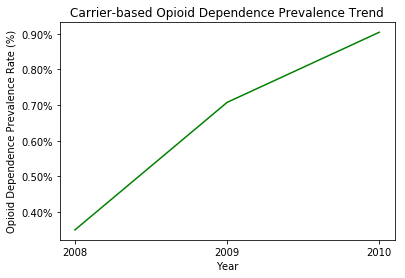

In [417]:
year = ['2008', '2009', '2010']
in_rate = [car_df.iloc[car_index][car_df.iloc[car_index]['year'].isin(['2008'])]['DESYNPUF_ID'].nunique() / car_df[car_df['year'].isin(['2008'])]['DESYNPUF_ID'].nunique(),
           car_df.iloc[car_index][car_df.iloc[car_index]['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique() / car_df[car_df['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].nunique(),
           car_df.iloc[car_index][car_df.iloc[car_index]['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique() / car_df[car_df['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].nunique()]

plt.plot(year, in_rate, color='g')
plt.xlabel('Year')
plt.ylabel('Opioid Dependence Prevalence Rate (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Carrier-based Opioid Dependence Prevalence Trend')
plt.show()

Wow! It seems that the **prevalence** rate has TRIPLED on a cumulative basis in Carrier-based (read: non-institutional) patients from 2008 to 2010. We should now get a sense for the demographics and geographic location of the Medicare population as well, and see if they are located in states with doctors that have **clearance** to prescribe drugs such as Suboxone.

## Join beneficiary data to claims data
First, let's get a consolidated list of the total **unique** beneficiaries across our 3 data sets.

In [256]:
tot_ids = list(set().union(in_ids, out_ids, car_ids))

Then, let's load the beneficiary data and explore it to get a sense for patient demographics and geographic distribution. Geographic distribution is important because some states have more physicians that are able to prescribe Suboxone than others.

In [449]:
# ben = pd.read_csv('./DE1_0_2008_Beneficiary_Summary_File_Sample_1.csv')
ben = pd.concat(map(pd.read_csv, ['../DE1_0_2008_Beneficiary_Summary_File_Sample_1.csv', 
                                  '../DE1_0_2009_Beneficiary_Summary_File_Sample_1.csv',
                                  '../DE1_0_2010_Beneficiary_Summary_File_Sample_1.csv']))

### Create new state, sex, and race columns with actual values

The `state`, `sex`, and `race` in this table are coded, so let's assign the actual values to the codes. We have to create dictionaries for each and then use a function to create a new column based on the dictionary values:

#### State

In [450]:
state_d = {
    1: 'AL', 2: 'AK', 3: 'AZ', 4: 'AR', 5: 'CA', 6: 'CO', 7: 'CT', 8: 'DE', 9: 'DC', 10: 'FL', 11: 'GA', 12: 'HI',
    13: 'ID', 14: 'IL', 15: 'IN', 16: 'IA', 17: 'KS', 18: 'KY', 19: 'LA', 20: 'ME', 21: 'MD', 22: 'MA', 23: 'MI',
    24: 'MN', 25: 'MS', 26: 'MO', 27: 'MT', 28: 'NE', 29: 'NV', 30: 'NH', 31: 'NJ', 32: 'NM', 33: 'NY', 34: 'NC',
    35: 'ND', 36: 'OH', 37: 'OK', 38: 'OR', 39: 'PA', 41: 'RI', 42: 'SC', 43: 'SD', 44: 'TN', 45: 'TX', 46: 'UT',
    47: 'VT', 49: 'VA', 50: 'WA', 51: 'WV', 52: 'WI', 53: 'WY', 54: 'Others'
}

In [451]:
ben['state'] = ben['SP_STATE_CODE'].map(state_d)

#### Sex

In [452]:
sex_d = {
    1: 'M',
    2: 'F'
}

In [453]:
ben['sex'] = ben['BENE_SEX_IDENT_CD'].map(sex_d)

#### Race

In [454]:
race_d = {
    1: 'White',
    2: 'Black',
    3: 'Others',
    5: 'Hispanic'
}

In [455]:
ben['race'] = ben['BENE_RACE_CD'].map(race_d)

Now let's create a summary dataframe containing only those rows corresponding to our targeted beneficiary population.

In [456]:
ben_df = ben[ben['DESYNPUF_ID'].isin(tot_ids)]

### Geographic Distribution

Let's look at the geographic distribution of the beneficiaries:

In [474]:
state_pivot = pd.pivot_table(ben_df, index=['state'], aggfunc='count')['DESYNPUF_ID'].sort_values(ascending=False)
state_pivot_pct = state_pivot.transform(lambda x: x/x.sum())
state_pivot_cum_pct = state_pivot.cumsum()/state_pivot.sum()

In [475]:
states = pd.concat([state_pivot,state_pivot_pct, state_pivot_cum_pct], axis=1)
states.columns = ['# Beneficiaries', '% of tot.', 'cum % of tot.']

We can place our initial focus on the states that represent `80%` of the total sample. We can compare this internal data against outside physician capacity data to see which states have a low (read: good) `ratio` of `population with opioid dependence` to `maximum physician capacity`:

In [459]:
states[states['cum % of tot.'] <=.81]

,# Beneficiaries,% of tot.,cum % of tot.
state,,,
CA,303,0.076303,0.076303
FL,272,0.068497,0.144800
NY,272,0.068497,0.213296
TX,230,0.057920,0.271216
OH,211,0.053135,0.324352
PA,204,0.051372,0.375724
IL,158,0.039788,0.415512
MI,150,0.037774,0.453286
NC,135,0.033996,0.487283


Let's add a few columns of data here from outside research:
- **implied population** with opioid dependence in each state, since our sample represents .25% of the actual population
- **total available patient capacity** in each state, based on number of physicians cleared to prescribe Suboxone
- **implied population % of capacity** in each state
- **Compound Annual Growth Rate (CAGR)** of physicians between 2008-2010

#### Implied population

In [497]:
impl_pop_d = {
    'CA': 40400,
    'FL': 36267,
    'NY': 36267,
    'TX': 30667,
    'OH': 28134,
    'PA': 27200,
    'IL': 21067,
    'MI': 20000,
    'NC': 18000,
    'NJ': 16000,
    'IN': 16000,
    'GA': 15600,
    'MA': 14400,
    'TN': 12800,
    'KY': 12000,
    'MO': 12000,
    'VA': 11734,
    'LA': 10400,
    'AZ': 9600,
    'AL': 9467,
    'WA': 9200,
    'SC': 8667,
    'WI': 8400,
}

In [498]:
states['implied pop.'] = states.index.map(impl_pop_d)

#### Total capacity

In [499]:
capacity_d = {
    'CA': 111330,
    'FL': 78420,
    'NY': 116720,
    'TX': 52830,
    'OH': 35860,
    'PA': 69010,
    'IL': 24990,
    'MI': 50630,
    'NC': 21430,
    'NJ': 47540,
    'IN': 15870,
    'GA': 28510,
    'MA': 55810,
    'TN': 24270,
    'KY': 17480,
    'MO': 11400,
    'VA': 19890,
    'LA': 17950,
    'AZ': 18810,
    'AL': 17100,
    'WA': 23610,
    'SC': 11250,
    'WI': 16690,
}

In [500]:
states['tot. capacity'] = states.index.map(capacity_d)

#### Population % of capacity

In [506]:
pop_pct_cap_d = {
    'CA': 0.362885116320848,
    'FL': 0.46246705772337,
    'NY': 0.310715101667809,
    'TX': 0.580478263612846,
    'OH': 0.784532440974159,
    'PA': 0.394145775974496,
    'IL': 0.843003868213952,
    'MI': 0.395022713806044,
    'NC': 0.839944003733084,
    'NJ': 0.336558687421119,
    'IN': 1.00819155639572,
    'GA': 0.547176429323045,
    'MA': 0.258018276294571,
    'TN': 0.527400082406263,
    'KY': 0.68649885583524,
    'MO': 1.05263157894737,
    'VA': 0.589911178146472,
    'LA': 0.579387186629526,
    'AZ': 0.5103668261563,
    'AL': 0.553606237816764,
    'WA': 0.389665396018636,
    'SC': 0.77037037037037,
    'WI': 0.503295386458957,
}

In [507]:
states['pop. % of capacity'] = states.index.map(pop_pct_cap_d)

#### 2008-2010 physician CAGR

In [503]:
cagr_d = {
    'CA': 0.152958556425955,
    'FL': 0.207431903442212,
    'NY': 0.186074842749034,
    'TX': 0.200613758457996,
    'OH': 0.206381839575324,
    'PA': 0.201299310521239,
    'IL': 0.152626845227074,
    'MI': 0.200165943955198,
    'NC': 0.238105063709852,
    'NJ': 0.150273143665266,
    'IN': 0.158233417406421,
    'GA': 0.179005357228902,
    'MA': 0.189261804283746,
    'TN': 0.281871938569664,
    'KY': 0.278738854861923,
    'MO': 0.201265155860081,
    'VA': 0.185183959117382,
    'LA': 0.167452821144208,
    'AZ': 0.123572920367232,
    'AL': 0.28165958695356,
    'WA': 0.223579372439516,
    'SC': 0.142411663260082,
    'WI': 0.187277717460569,
}

In [508]:
states['2008-10 Phys CAGR'] = states.index.map(cagr_d)

## Analysis: Geographic Distribution

I've sorted the below table (remember: the below states make up 80% of the sample population) by the `population % of capacity` column to see which states have a high ratio of population to capacity (which indicates there are not enough physicians to service the population). It turns out 6 states have high ratios (above 75%):
- MO (Missouri)
- IN (Indiana)
- OH (Ohio)
- IL (Illinois)
- NC (North Carolina)
- SC (South Carolina)

**MO and IN**: Of the 6 states, 2 (MO and IN) have ratios above 100%, which means there are not enough physicians to treat the total population in the state. Therefore, the number of prescriptions that can be written in those states is limited by this ceiling.

**IL and SC**: Of the remaining 4 states, 2 states, IL and SC, have both ratios north of 75% AND physician CAGRs in the mid-teens, making those states relatively unfavorable for prescriptions that can be written.

**OH and NC**: The final 2 states, OH and NC, saw physician CAGRs of 20%+, indicating that while constrained, physician capacity has been growing and may point to increased growth going forward easing capacity issues.

When OH and NC are taken out of the 6 states, the remaining 4 states with high capacity-constraint ratios represent only 13.5% of the population, indicating that the majority of states have significant capacity, and in some cases, high physician growth rates, making the environment favorable for Suboxone prescription growth.

In [509]:
states[states['cum % of tot.'] <=.81][['# Beneficiaries', 
                                       'implied pop.',
                                       'tot. capacity',
                                       'pop. % of capacity',
                                       '2008-10 Phys CAGR']].sort_values('pop. % of capacity', ascending=False)

,# Beneficiaries,implied pop.,tot. capacity,pop. % of capacity,2008-10 Phys CAGR
state,,,,,
MO,90,12000.0,11400.0,1.052632,0.201265
IN,120,16000.0,15870.0,1.008192,0.158233
IL,158,21067.0,24990.0,0.843004,0.152627
NC,135,18000.0,21430.0,0.839944,0.238105
OH,211,28134.0,35860.0,0.784532,0.206382
SC,65,8667.0,11250.0,0.770370,0.142412
KY,90,12000.0,17480.0,0.686499,0.278739
VA,88,11734.0,19890.0,0.589911,0.185184
TX,230,30667.0,52830.0,0.580478,0.200614


# Conclusion
Given the rapid growth in the prevalence of opioid dependence in the Medicare population (and having outpaced Suboxone revenue growth), combined with comfortable levels of available prescribing capacity in various states, I recommend a long position in RB.L.

# --Memo--

In [469]:
op_unique_out_08 = list(out_df.iloc[out_index][out_df.iloc[out_index]['year'].isin(['2008'])]['DESYNPUF_ID'].unique())
op_unique_out_09 = list(out_df.iloc[out_index][out_df.iloc[out_index]['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].unique())
op_unique_out_10 = list(out_df.iloc[out_index][out_df.iloc[out_index]['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].unique())

In [470]:
op_unique_in_08 = list(in_df.iloc[in_index][in_df.iloc[in_index]['year'].isin(['2008'])]['DESYNPUF_ID'].unique())
op_unique_in_09 = list(in_df.iloc[in_index][in_df.iloc[in_index]['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].unique())
op_unique_in_10 = list(in_df.iloc[in_index][in_df.iloc[in_index]['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].unique())

In [471]:
op_unique_car_08 = list(car_df.iloc[car_index][car_df.iloc[car_index]['year'].isin(['2008'])]['DESYNPUF_ID'].unique())
op_unique_car_09 = list(car_df.iloc[car_index][car_df.iloc[car_index]['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].unique())
op_unique_car_10 = list(car_df.iloc[car_index][car_df.iloc[car_index]['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].unique())

In [472]:
op_unique_ids_08 = list(set().union(op_unique_out_08, 
                                       op_unique_in_08,
                                       op_unique_car_08))

In [437]:
op_unique_ids_08_09 = list(set().union(op_unique_out_08, 
                                       op_unique_out_09,
                                       op_unique_in_08,
                                       op_unique_in_09,
                                       op_unique_car_08,
                                       op_unique_car_09))

In [428]:
op_unique_ids_08_10 = list(set().union(op_unique_out_08, 
                                       op_unique_out_09,
                                       op_unique_out_10,
                                       op_unique_in_08,
                                       op_unique_in_09,
                                       op_unique_in_10,
                                       op_unique_car_08,
                                       op_unique_car_09,
                                       op_unique_car_10,))

In [440]:
len(op_unique_ids_08), len(op_unique_ids_08_09), len(op_unique_ids_08_10)

(447, 1008, 1331)

In [424]:
tot_unique_out_08 = list(out_df[out_df['year'].isin(['2008'])]['DESYNPUF_ID'].unique())
tot_unique_out_09 = list(out_df[out_df['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].unique())
tot_unique_out_10 = list(out_df[out_df['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].unique())

In [432]:
tot_unique_in_08 = list(in_df[in_df['year'].isin(['2008'])]['DESYNPUF_ID'].unique())
tot_unique_in_09 = list(in_df[in_df['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].unique())
tot_unique_in_10 = list(in_df[in_df['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].unique())

In [427]:
tot_unique_car_08 = list(car_df[car_df['year'].isin(['2008'])]['DESYNPUF_ID'].unique())
tot_unique_car_09 = list(car_df[car_df['year'].isin(['2008', '2009'])]['DESYNPUF_ID'].unique())
tot_unique_car_10 = list(car_df[car_df['year'].isin(['2008', '2009', '2010'])]['DESYNPUF_ID'].unique())

In [444]:
tot_unique_ids_08 = list(set().union(tot_unique_out_08, 
                                        tot_unique_in_08,
                                        tot_unique_car_08))

In [445]:
tot_unique_ids_08_09 = list(set().union(tot_unique_out_08, 
                                        tot_unique_out_09,
                                        tot_unique_in_08,
                                        tot_unique_in_09,
                                        tot_unique_car_08,
                                        tot_unique_car_09))

In [446]:
tot_unique_ids_08_10 = list(set().union(tot_unique_out_08, 
                                        tot_unique_out_09,
                                        tot_unique_out_10,
                                        tot_unique_in_08,
                                        tot_unique_in_09,
                                        tot_unique_in_10,
                                        tot_unique_car_08,
                                        tot_unique_car_09,
                                        tot_unique_car_10,))

In [447]:
len(tot_unique_ids_08), len(tot_unique_ids_08_09), len(tot_unique_ids_08_10)

(86209, 95454, 99210)